In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# TabNet 폐업률 분류 예측 모델

**목표**: 서울시 상권 데이터를 활용한 폐업 위험도 분류 (High Risk / Low Risk)

**사용모델**:
- TabNet (Attention-based Tabular Deep Learning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 라이브러리 임포트 및 GPU 설정

In [4]:
!pip install optuna pytorch-tabnet imbalanced-learn -q

In [5]:
# 필요 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, average_precision_score
)
from sklearn.utils.class_weight import compute_class_weight

# SMOTE
from imblearn.over_sampling import SMOTE

# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier



# 시드 설정
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print("✓ 라이브러리 임포트 완료")

✓ 라이브러리 임포트 완료


In [ ]:
# GPU 설정 (Mac GPU 자동 감지)
if torch.backends.mps.is_available():
    device = 'mps'
    print("Mac GPU 사용")
elif torch.cuda.is_available():
    device = 'cuda'
    print("NVIDIA GPU 사용")
else:
    device = 'cpu'
    print("GPU 사용 불가, CPU 사용")

print(f"Device: {device}")

✓ NVIDIA GPU 사용
Device: cuda


## 2. 데이터 로드 및 탐색

In [7]:
# 데이터 로드
data_path = '/content/drive/MyDrive/merged_data.csv'
df = pd.read_csv(data_path)

print(f"✓ 데이터 로드 완료")
print(f"  - Shape: {df.shape}")
print(f"  - 행 수: {len(df):,}")
print(f"  - 컬럼 수: {len(df.columns)}")

✓ 데이터 로드 완료
  - Shape: (39975, 137)
  - 행 수: 39,975
  - 컬럼 수: 137


In [8]:
# 데이터 미리보기
print("\n[데이터 미리보기]")
df.head()


[데이터 미리보기]


,기준_년분기_코드,자치구_코드_명,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_률,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,20191,강남구,PC방,122.0,132.0,9.8,13.0,6.8,9.0,10.0,...,178522.0,164466.0,100728.0,44021.0,1679.0,99408.0,108205.0,74466.0,54523.0,22838.0
1,20191,강남구,가구,435.0,436.0,2.8,12.0,0.7,3.0,1.0,...,178522.0,164466.0,100728.0,44021.0,1679.0,99408.0,108205.0,74466.0,54523.0,22838.0
2,20191,강남구,가방,279.0,280.0,4.3,12.0,3.6,10.0,1.0,...,178522.0,164466.0,100728.0,44021.0,1679.0,99408.0,108205.0,74466.0,54523.0,22838.0
3,20191,강남구,가전제품,163.0,163.0,1.8,3.0,1.2,2.0,0.0,...,178522.0,164466.0,100728.0,44021.0,1679.0,99408.0,108205.0,74466.0,54523.0,22838.0
4,20191,강남구,가전제품수리,92.0,92.0,3.3,3.0,1.1,1.0,0.0,...,178522.0,164466.0,100728.0,44021.0,1679.0,99408.0,108205.0,74466.0,54523.0,22838.0



[폐업률 통계]
count    39975.000000
mean         2.589829
std          2.001541
min          0.000000
25%          1.200000
50%          2.300000
75%          3.600000
max         33.300000
Name: 폐업_률, dtype: float64


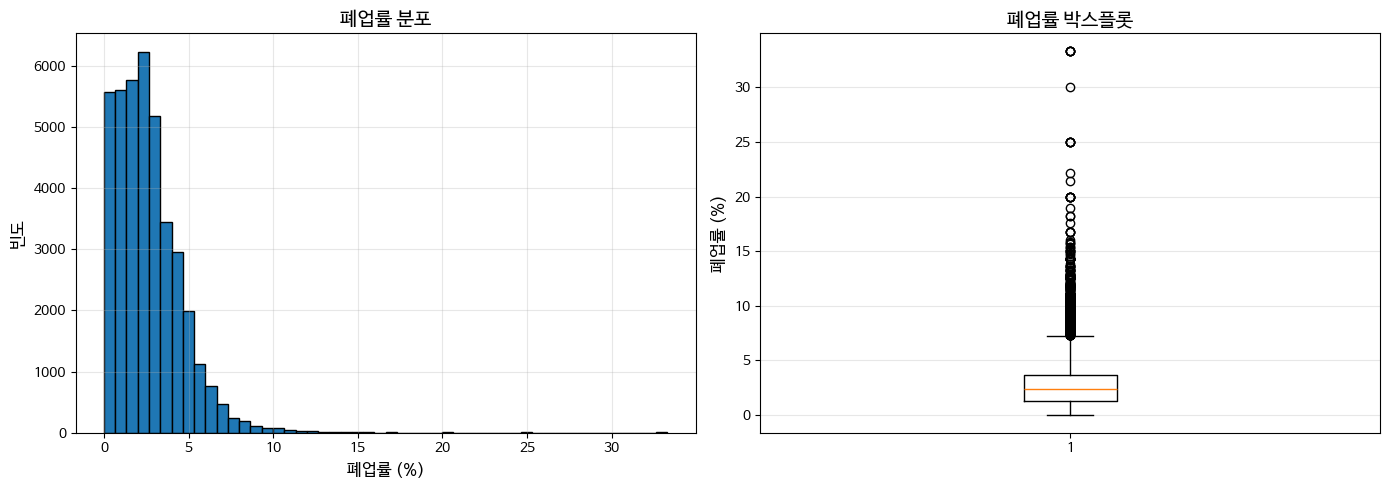

In [9]:
# 기본 통계
print("\n[폐업률 통계]")
print(df['폐업_률'].describe())

# 폐업률 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['폐업_률'], bins=50, edgecolor='black')
axes[0].set_xlabel('폐업률 (%)', fontsize=12)
axes[0].set_ylabel('빈도', fontsize=12)
axes[0].set_title('폐업률 분포', fontsize=14)
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df['폐업_률'])
axes[1].set_ylabel('폐업률 (%)', fontsize=12)
axes[1].set_title('폐업률 박스플롯', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. 타겟 변수 생성

In [10]:
# 폐업률 상위 50%를 High Risk로 분류
threshold_percentile = 50
threshold = df['폐업_률'].quantile(threshold_percentile / 100)

df['closure_risk'] = (df['폐업_률'] >= threshold).astype(int)

print(f"✓ 타겟 변수 생성 완료")
print(f"  - 폐업률 임계값: {threshold:.2f}%")
print(f"\n✓ 클래스 분포:")
print(df['closure_risk'].value_counts())
print(f"\n✓ 클래스 비율:")
for cls, count in df['closure_risk'].value_counts().items():
    print(f"  - Class {cls}: {count/len(df)*100:.2f}%")

✓ 타겟 변수 생성 완료
  - 폐업률 임계값: 2.30%

✓ 클래스 분포:
closure_risk
1    20320
0    19655
Name: count, dtype: int64

✓ 클래스 비율:
  - Class 1: 50.83%
  - Class 0: 49.17%


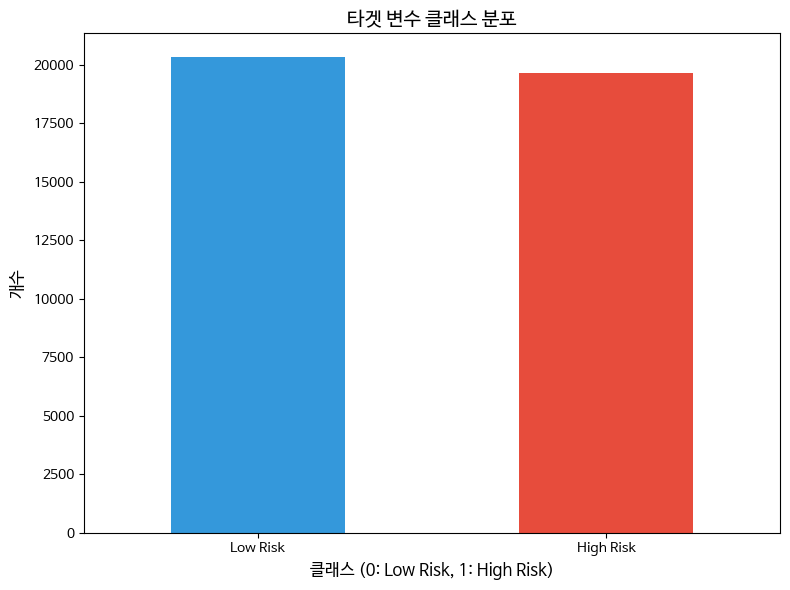

In [11]:
# 클래스 분포 시각화
fig, ax = plt.subplots(figsize=(8, 6))
df['closure_risk'].value_counts().plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'])
ax.set_xlabel('클래스 (0: Low Risk, 1: High Risk)', fontsize=12)
ax.set_ylabel('개수', fontsize=12)
ax.set_title('타겟 변수 클래스 분포', fontsize=14)
ax.set_xticklabels(['Low Risk', 'High Risk'], rotation=0)
plt.tight_layout()
plt.show()

## 4. 데이터 전처리

In [ ]:
# 범주형 변수 인코딩
print("✓ 범주형 변수 인코딩")

# 자치구 인코딩
le_district = LabelEncoder()
df['자치구_encoded'] = le_district.fit_transform(df['자치구_코드_명'])
print(f"  - 자치구: {len(le_district.classes_)}개")

# 업종 인코딩
le_industry = LabelEncoder()
df['업종_encoded'] = le_industry.fit_transform(df['서비스_업종_코드_명'])
print(f"  - 업종: {len(le_industry.classes_)}개")

# 상권변화지표 인코딩
le_change = LabelEncoder()
df['상권변화_encoded'] = le_change.fit_transform(df['상권_변화_지표'])
print(f"  - 상권 변화 지표: {len(le_change.classes_)}개")

# 분기 정보 추출
df['year'] = df['기준_년분기_코드'].astype(str).str[:4].astype(int)
df['quarter'] = df['기준_년분기_코드'].astype(str).str[4:].astype(int)
df['year_quarter'] = df['year'] * 10 + df['quarter']

print(f"  - 분기 범위: {df['year_quarter'].min()} ~ {df['year_quarter'].max()}")

# Feature Engineering
print("\n✓ Feature Engineering")

# 시계열 순서대로 정렬
df = df.sort_values(['자치구_encoded', '업종_encoded', 'year_quarter'])

# Interaction Features
df['점포당_매출'] = df['당월_매출_금액'] / (df['점포_수'] + 1)
df['건당_매출'] = df['당월_매출_금액'] / (df['당월_매출_건수'] + 1)
df['점포당_유동인구'] = df['총_유동인구_수'] / (df['점포_수'] + 1)
# 지난 분기(lag1)의 개업률, 폐업률 -> 해당 분기 이전 폐업률 활용
df['개업_률_lag1'] = df.groupby(['자치구_encoded', '업종_encoded'])['개업_률'].shift(1)
df['폐업_률_lag1'] = df.groupby(['자치구_encoded', '업종_encoded'])['폐업_률'].shift(1)
# 지난 분기의 개폐업 비율
df['개폐업_비율_lag1'] = df['개업_률_lag1'] / (df['폐업_률_lag1'] + 0.1)

# Ratio Features
df['남성_매출_비율'] = df['남성_매출_금액'] / (df['당월_매출_금액'] + 1)
df['여성_매출_비율'] = df['여성_매출_금액'] / (df['당월_매출_금액'] + 1)
df['주말_매출_비율'] = (df['토요일_매출_금액'] + df['일요일_매출_금액']) / (df['당월_매출_금액'] + 1)
df['야간_매출_비율'] = (df['시간대_00_06_매출_금액'] + df['시간대_21_24_매출_금액']) / (df['당월_매출_금액'] + 1)
df['연령대_20_매출_비율'] = df['연령대_20_매출_금액'] / (df['당월_매출_금액'] + 1)
df['연령대_30_매출_비율'] = df['연령대_30_매출_금액'] / (df['당월_매출_금액'] + 1)


# Aggregation Features
df['총_인구'] = df['총_유동인구_수'] + df['총_상주인구_수'] + df['총_직장인구_수']
df['1인당_소득'] = df['월_평균_소득_금액'] / (df['총_상주인구_수'] + 1)
df['소득지출비율'] = df['월_평균_소득_금액'] / (df['지출_총_금액'] + 1)
df['점포당_가구수'] = df['총_가구_수'] / (df['점포_수'] + 1)


# Density Features
df['유동인구_밀집도'] = df['총_유동인구_수'] / (df['총_상주인구_수'] + 1)
df['직장인구_비율'] = df['총_직장인구_수'] / (df['총_상주인구_수'] + 1)
df['점포_밀집도'] = df['점포_수'] / (df['유사_업종_점포_수'] + 1)


# Competition Features
df['프랜차이즈_비율'] = df['프랜차이즈_점포_수'] / (df['점포_수'] + 1)
df['경쟁도'] = df['유사_업종_점포_수'] / (df['점포_수'] + 1)



print(f"  - 현재 총 컬럼 수: {len(df.columns)}")

✓ 범주형 변수 인코딩
  - 자치구: 25개
  - 업종: 63개
  - 상권 변화 지표: 4개
  - 분기 범위: 20191 ~ 20252

✓ Feature Engineering
  - 현재 총 컬럼 수: 165


In [13]:
# Feature 선택
print("\n✓ Feature 선택")

# 범주형 변수 (인코딩된 버전 사용)
categorical_features = ['자치구_encoded', '업종_encoded', '상권변화_encoded']

# 제외할 컬럼들
exclude_cols = [
    # 원본 범주형 변수 (인코딩 전)
    '기준_년분기_코드', '자치구_코드_명', '서비스_업종_코드_명', '상권_변화_지표',

    # 타겟 변수 및 타겟과 직접 연관된 변수
    '폐업_률', '폐업_점포_수', 'closure_risk',

    # 시간 정보 (정렬용으로만 사용)
    'year', 'quarter', 'year_quarter'
]

# 사용 가능한 feature 선택
feature_cols = [col for col in df.columns if col not in exclude_cols]

# 범주형 feature의 인덱스 및 차원 설정 (TabNet용)
cat_idxs = [feature_cols.index(col) for col in categorical_features]
cat_dims = [
    len(le_district.classes_),
    len(le_industry.classes_),
    len(le_change.classes_)
]

print(f"  - 전체 컬럼 수: {len(df.columns)}")
print(f"  - 제외 컬럼 수: {len(exclude_cols)}")
print(f"  - 사용 feature 수: {len(feature_cols)}")
print(f"\n  - 범주형 feature: {len(categorical_features)}개")
print(f"    - cat_idxs: {cat_idxs}")
print(f"    - cat_dims: {cat_dims}")


✓ Feature 선택
  - 전체 컬럼 수: 165
  - 제외 컬럼 수: 10
  - 사용 feature 수: 155

  - 범주형 feature: 3개
    - cat_idxs: [131, 132, 133]
    - cat_dims: [25, 63, 4]


In [14]:
# 결측치 처리
print("\n✓ 결측치 처리")

# 무한대 값 처리
df = df.replace([np.inf, -np.inf], np.nan)

# 결측치 확인
missing_counts = df[feature_cols].isnull().sum()
missing_features = missing_counts[missing_counts > 0]

if len(missing_features) > 0:
    print(f"  - 결측치가 있는 feature: {len(missing_features)}개")
    for feat, count in missing_features.items():
        print(f"    - {feat}: {count}개 ({count/len(df)*100:.2f}%)")
else:
    print("  - 결측치 없음")

# 결측치가 있는 행 제거
df_clean = df.dropna(subset=feature_cols)
removed_rows = len(df) - len(df_clean)

print(f"\n  - 제거된 행 수: {removed_rows} ({removed_rows/len(df)*100:.2f}%)")
print(f"  - 최종 데이터 shape: {df_clean.shape}")


✓ 결측치 처리
  - 결측치가 있는 feature: 3개
    - 개업_률_lag1: 1556개 (3.89%)
    - 폐업_률_lag1: 1556개 (3.89%)
    - 개폐업_비율_lag1: 1556개 (3.89%)

  - 제거된 행 수: 1556 (3.89%)
  - 최종 데이터 shape: (38419, 165)


## 5. 데이터 분할

In [15]:
# 시계열 순서대로 정렬
df_sorted = df_clean.sort_values('year_quarter')

# Train/Val/Test 분할
train_size = 0.7
val_size = 0.1
test_size = 0.2

n_total = len(df_sorted)
n_train = int(n_total * train_size)
n_val = int(n_total * val_size)

train_df = df_sorted.iloc[:n_train]
val_df = df_sorted.iloc[n_train:n_train+n_val]
test_df = df_sorted.iloc[n_train+n_val:]

# 범주형과 연속형 분리
categorical_mask = np.zeros(len(feature_cols), dtype=bool)
for idx in cat_idxs:
    categorical_mask[idx] = True

continuous_mask = ~categorical_mask

# 데이터 추출
X_train = train_df[feature_cols].values
y_train = train_df['closure_risk'].values

X_val = val_df[feature_cols].values
y_val = val_df['closure_risk'].values

X_test = test_df[feature_cols].values
y_test = test_df['closure_risk'].values

print("✓ 데이터 분할 완료")
print(f"\n  Train: {X_train.shape} ({len(X_train)/n_total*100:.1f}%)")
print(f"    - Class 0: {(y_train==0).sum()}, Class 1: {(y_train==1).sum()}")
print(f"\n  Validation: {X_val.shape} ({len(X_val)/n_total*100:.1f}%)")
print(f"    - Class 0: {(y_val==0).sum()}, Class 1: {(y_val==1).sum()}")
print(f"\n  Test: {X_test.shape} ({len(X_test)/n_total*100:.1f}%)")
print(f"    - Class 0: {(y_test==0).sum()}, Class 1: {(y_test==1).sum()}")

✓ 데이터 분할 완료

  Train: (26893, 155) (70.0%)
    - Class 0: 13447, Class 1: 13446

  Validation: (3841, 155) (10.0%)
    - Class 0: 1791, Class 1: 2050

  Test: (7685, 155) (20.0%)
    - Class 0: 3695, Class 1: 3990


In [16]:
# Feature 스케일링 (연속형 변수만)
print("\n✓ Feature 스케일링 (연속형 변수만)")

# 연속형 변수만 스케일링
scaler = StandardScaler()
X_train_continuous = X_train[:, continuous_mask].astype(np.float64)
X_val_continuous = X_val[:, continuous_mask].astype(np.float64)
X_test_continuous = X_test[:, continuous_mask].astype(np.float64)

X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
X_val_continuous_scaled = scaler.transform(X_val_continuous)
X_test_continuous_scaled = scaler.transform(X_test_continuous)

# 범주형과 스케일링된 연속형 결합
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[:, continuous_mask] = X_train_continuous_scaled
X_val_scaled[:, continuous_mask] = X_val_continuous_scaled
X_test_scaled[:, continuous_mask] = X_test_continuous_scaled

# MPS 호환성
if device == 'mps':
    X_train_scaled = X_train_scaled.astype(np.float32)
    X_val_scaled = X_val_scaled.astype(np.float32)
    X_test_scaled = X_test_scaled.astype(np.float32)

print(f"  - 연속형 feature 수: {continuous_mask.sum()}개")
print(f"  - 범주형 feature 수: {categorical_mask.sum()}개")
print(f"  - Train 평균: {X_train_continuous_scaled.mean():.6f}, 표준편차: {X_train_continuous_scaled.std():.6f}")
print(f"  - Val 평균: {X_val_continuous_scaled.mean():.6f}, 표준편차: {X_val_continuous_scaled.std():.6f}")
print(f"  - Test 평균: {X_test_continuous_scaled.mean():.6f}, 표준편차: {X_test_continuous_scaled.std():.6f}")


✓ Feature 스케일링 (연속형 변수만)
  - 연속형 feature 수: 152개
  - 범주형 feature 수: 3개
  - Train 평균: 0.000000, 표준편차: 1.000000
  - Val 평균: 0.009003, 표준편차: 1.098309
  - Test 평균: 0.032105, 표준편차: 1.134352


## 6. SMOTE 적용 (선택사항 - 균형 데이터에서는 불필요)

In [17]:
# SMOTE 제거
print("✓ 데이터 균형 확인")
print(f"\n  클래스 분포:")
print(f"    - Class 0: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"    - Class 1: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")
print(f"    - 비율: {(y_train==1).sum() / (y_train==0).sum():.3f}")

print(f"\n✓ SMOTE 제거 (이미 균형 잡힌 데이터)")
print(f"  - 원본 데이터로 학습 진행")

# SMOTE 적용하지 않음
X_train_resampled = X_train_scaled
y_train_resampled = y_train

✓ 데이터 균형 확인

  클래스 분포:
    - Class 0: 13447 (50.00%)
    - Class 1: 13446 (50.00%)
    - 비율: 1.000

✓ SMOTE 제거 (이미 균형 잡힌 데이터)
  - 원본 데이터로 학습 진행


In [18]:
# 클래스 가중치 계산 (SMOTE 적용 후)
print("\n✓ 클래스 가중치 계산")

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"  클래스 가중치:")
for cls, weight in weights_dict.items():
    print(f"    - Class {cls}: {weight:.4f}")


✓ 클래스 가중치 계산
  클래스 가중치:
    - Class 0: 1.0000
    - Class 1: 1.0000


## 7. TabNet 모델 학습 - Hyperparameter Tuning with Optuna

In [19]:
import optuna
from sklearn.metrics import roc_auc_score

def objective(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_d = trial.suggest_int("n_d", 8, 64, step=8)
    n_steps = trial.suggest_int("n_steps", 3, 10, step=1)
    gamma = trial.suggest_float("gamma", 1.0, 2.0, step=0.1)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    lr = trial.suggest_float("lr", 1e-3, 3e-2, log=True)

    model = TabNetClassifier(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=3,
        n_d=n_d,
        n_a=n_d,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        mask_type=mask_type,
        optimizer_params=dict(lr=lr),
        scheduler_params={"step_size":50, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        seed=SEED,
        verbose=0,
        device_name=device,
    )

    model.fit(
        X_train_resampled, y_train_resampled,
        eval_set=[(X_val_scaled, y_val)],
        max_epochs=50,
        patience=10,
        eval_metric=['auc'],
    )

    preds = model.predict_proba(X_val_scaled)[:, 1]
    auc = roc_auc_score(y_val, preds)

    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params

[I 2025-10-11 12:50:18,780] A new study created in memory with name: no-name-1fc8fcdc-95be-47fd-bbba-e91294db2063



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_auc = 0.76459


[I 2025-10-11 12:52:02,649] Trial 0 finished with value: 0.7645863463659762 and parameters: {'mask_type': 'entmax', 'n_d': 48, 'n_steps': 7, 'gamma': 1.7000000000000002, 'lambda_sparse': 0.0005786214128494909, 'lr': 0.0031082613888779175}. Best is trial 0 with value: 0.7645863463659762.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_auc = 0.80062


[I 2025-10-11 12:53:07,471] Trial 1 finished with value: 0.8006233062330623 and parameters: {'mask_type': 'entmax', 'n_d': 8, 'n_steps': 3, 'gamma': 1.9, 'lambda_sparse': 4.3226182827160935e-06, 'lr': 0.0055618654670690285}. Best is trial 1 with value: 0.8006233062330623.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_auc = 0.77711


[I 2025-10-11 12:55:32,546] Trial 2 finished with value: 0.7771099399436205 and parameters: {'mask_type': 'entmax', 'n_d': 48, 'n_steps': 9, 'gamma': 1.0, 'lambda_sparse': 1.092923103498013e-06, 'lr': 0.0012526488414497633}. Best is trial 1 with value: 0.8006233062330623.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_auc = 0.77942


[I 2025-10-11 12:56:52,114] Trial 3 finished with value: 0.7794220424616307 and parameters: {'mask_type': 'sparsemax', 'n_d': 64, 'n_steps': 4, 'gamma': 1.2, 'lambda_sparse': 5.837198148881796e-05, 'lr': 0.0017730647298382998}. Best is trial 1 with value: 0.8006233062330623.


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_auc = 0.80008


[I 2025-10-11 12:57:56,644] Trial 4 finished with value: 0.800076534433686 and parameters: {'mask_type': 'entmax', 'n_d': 16, 'n_steps': 3, 'gamma': 1.1, 'lambda_sparse': 2.5105890925763314e-05, 'lr': 0.0034777052894757916}. Best is trial 1 with value: 0.8006233062330623.



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_auc = 0.7657


[I 2025-10-11 12:59:20,074] Trial 5 finished with value: 0.7656967765657555 and parameters: {'mask_type': 'entmax', 'n_d': 16, 'n_steps': 5, 'gamma': 1.3, 'lambda_sparse': 0.0001401927397598974, 'lr': 0.001389019426448966}. Best is trial 1 with value: 0.8006233062330623.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_auc = 0.78452


[I 2025-10-11 13:00:37,763] Trial 6 finished with value: 0.7845228854298594 and parameters: {'mask_type': 'entmax', 'n_d': 24, 'n_steps': 4, 'gamma': 1.6, 'lambda_sparse': 5.3866210832816634e-05, 'lr': 0.002237916897136346}. Best is trial 1 with value: 0.8006233062330623.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_auc = 0.75816


[I 2025-10-11 13:02:32,446] Trial 7 finished with value: 0.7581648077787311 and parameters: {'mask_type': 'entmax', 'n_d': 24, 'n_steps': 10, 'gamma': 1.2, 'lambda_sparse': 7.763507888013234e-05, 'lr': 0.004792829539888534}. Best is trial 1 with value: 0.8006233062330623.


Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_val_0_auc = 0.74427


[I 2025-10-11 13:03:49,939] Trial 8 finished with value: 0.744265228581934 and parameters: {'mask_type': 'sparsemax', 'n_d': 16, 'n_steps': 4, 'gamma': 1.1, 'lambda_sparse': 2.004685335575321e-05, 'lr': 0.0012803693538258776}. Best is trial 1 with value: 0.8006233062330623.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_auc = 0.72719


[I 2025-10-11 13:05:59,980] Trial 9 finished with value: 0.7271879723822364 and parameters: {'mask_type': 'entmax', 'n_d': 8, 'n_steps': 8, 'gamma': 2.0, 'lambda_sparse': 0.00011697741139011645, 'lr': 0.0043081398466999305}. Best is trial 1 with value: 0.8006233062330623.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_auc = 0.75677


[I 2025-10-11 13:07:29,996] Trial 10 finished with value: 0.7567713908294862 and parameters: {'mask_type': 'sparsemax', 'n_d': 40, 'n_steps': 6, 'gamma': 2.0, 'lambda_sparse': 2.7119233168072094e-06, 'lr': 0.012443111038930511}. Best is trial 1 with value: 0.8006233062330623.


Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_auc = 0.81906


[I 2025-10-11 13:08:33,926] Trial 11 finished with value: 0.8190610232735493 and parameters: {'mask_type': 'entmax', 'n_d': 8, 'n_steps': 3, 'gamma': 1.4, 'lambda_sparse': 8.535518208081139e-06, 'lr': 0.01064696992621617}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_auc = 0.8124


[I 2025-10-11 13:09:20,559] Trial 12 finished with value: 0.8123950375182143 and parameters: {'mask_type': 'entmax', 'n_d': 8, 'n_steps': 3, 'gamma': 1.4, 'lambda_sparse': 6.473291337821476e-06, 'lr': 0.00999849858110685}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_auc = 0.78457


[I 2025-10-11 13:10:05,795] Trial 13 finished with value: 0.7845701406762811 and parameters: {'mask_type': 'entmax', 'n_d': 24, 'n_steps': 6, 'gamma': 1.4, 'lambda_sparse': 9.831091359403984e-06, 'lr': 0.024985534986685227}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_auc = 0.80886


[I 2025-10-11 13:11:04,873] Trial 14 finished with value: 0.8088626057114843 and parameters: {'mask_type': 'sparsemax', 'n_d': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 7.036351907298579e-06, 'lr': 0.00966755072438152}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_auc = 0.7919


[I 2025-10-11 13:12:17,540] Trial 15 finished with value: 0.7918974275169888 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_steps': 5, 'gamma': 1.7000000000000002, 'lambda_sparse': 2.208514717357715e-06, 'lr': 0.010056786131170272}. Best is trial 11 with value: 0.8190610232735493.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_auc = 0.81883


[I 2025-10-11 13:13:48,090] Trial 16 finished with value: 0.8188252917705057 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_steps': 5, 'gamma': 1.4, 'lambda_sparse': 1.420766007796661e-05, 'lr': 0.017468248517993546}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_auc = 0.805


[I 2025-10-11 13:14:54,355] Trial 17 finished with value: 0.8050000680911332 and parameters: {'mask_type': 'entmax', 'n_d': 64, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 1.4211047737055736e-05, 'lr': 0.026833492780093983}. Best is trial 11 with value: 0.8190610232735493.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_auc = 0.76942


[I 2025-10-11 13:16:51,440] Trial 18 finished with value: 0.7694171399000422 and parameters: {'mask_type': 'sparsemax', 'n_d': 40, 'n_steps': 7, 'gamma': 1.7000000000000002, 'lambda_sparse': 0.0002722962738689604, 'lr': 0.017610216364155273}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_auc = 0.80616


[I 2025-10-11 13:18:07,848] Trial 19 finished with value: 0.8061597962713295 and parameters: {'mask_type': 'entmax', 'n_d': 56, 'n_steps': 4, 'gamma': 1.3, 'lambda_sparse': 3.282931687116339e-05, 'lr': 0.006989116772118993}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_auc = 0.79242


[I 2025-10-11 13:19:03,282] Trial 20 finished with value: 0.7924228187005489 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 1.4823307073703146e-06, 'lr': 0.016948668851852963}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_auc = 0.8093


[I 2025-10-11 13:19:47,761] Trial 21 finished with value: 0.809300704062317 and parameters: {'mask_type': 'entmax', 'n_d': 16, 'n_steps': 3, 'gamma': 1.4, 'lambda_sparse': 5.908165186586008e-06, 'lr': 0.01348192455974682}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_auc = 0.78953


[I 2025-10-11 13:21:05,154] Trial 22 finished with value: 0.7895292179052443 and parameters: {'mask_type': 'entmax', 'n_d': 8, 'n_steps': 4, 'gamma': 1.4, 'lambda_sparse': 1.230596064974213e-05, 'lr': 0.00806859036267002}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_auc = 0.81839


[I 2025-10-11 13:21:57,139] Trial 23 finished with value: 0.8183884190600699 and parameters: {'mask_type': 'entmax', 'n_d': 24, 'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 3.71615362232154e-06, 'lr': 0.019133003834034323}. Best is trial 11 with value: 0.8190610232735493.


Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_val_0_auc = 0.81082


[I 2025-10-11 13:23:41,170] Trial 24 finished with value: 0.8108202257901975 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_steps': 6, 'gamma': 1.3, 'lambda_sparse': 4.093507798155199e-06, 'lr': 0.021094348833429272}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_auc = 0.81418


[I 2025-10-11 13:24:40,474] Trial 25 finished with value: 0.8141787528428048 and parameters: {'mask_type': 'entmax', 'n_d': 24, 'n_steps': 4, 'gamma': 1.6, 'lambda_sparse': 2.6708181896734256e-06, 'lr': 0.014535470474737352}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_auc = 0.80961


[I 2025-10-11 13:25:36,121] Trial 26 finished with value: 0.809612289087715 and parameters: {'mask_type': 'sparsemax', 'n_d': 40, 'n_steps': 3, 'gamma': 1.2, 'lambda_sparse': 1.6305782970204257e-05, 'lr': 0.019509532484367476}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_auc = 0.81296


[I 2025-10-11 13:26:38,682] Trial 27 finished with value: 0.81296046628808 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_steps': 5, 'gamma': 1.6, 'lambda_sparse': 3.782693731067419e-05, 'lr': 0.029146469517484314}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_auc = 0.79473


[I 2025-10-11 13:27:18,623] Trial 28 finished with value: 0.7947311081151013 and parameters: {'mask_type': 'entmax', 'n_d': 24, 'n_steps': 4, 'gamma': 1.3, 'lambda_sparse': 9.876567576141785e-06, 'lr': 0.012451624013410678}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_auc = 0.75456


[I 2025-10-11 13:28:42,011] Trial 29 finished with value: 0.7545636039274966 and parameters: {'mask_type': 'entmax', 'n_d': 48, 'n_steps': 7, 'gamma': 1.8, 'lambda_sparse': 0.0005435893068623584, 'lr': 0.0066882701588784075}. Best is trial 11 with value: 0.8190610232735493.


Best trial:
  Value: 0.8190610232735493
  Params: 
    mask_type: entmax
    n_d: 8
    n_steps: 3
    gamma: 1.4
    lambda_sparse: 8.535518208081139e-06
    lr: 0.01064696992621617


In [20]:
# TabNet 모델 생성
print("✓ TabNet 모델 생성")

model = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    n_d=best_params['n_d'],
    n_a=best_params['n_d'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    lambda_sparse=best_params['lambda_sparse'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_params['lr']),
    scheduler_params={"step_size": 50, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type=best_params['mask_type'],
    seed=SEED,
    verbose=1,
    device_name=device,
)

print(f"\n  모델 설정:")
print(f"    - cat_idxs: {cat_idxs}")
print(f"    - cat_dims: {cat_dims}")
print(f"    - cat_emb_dim: 3")
print(f"    - n_d: {best_params['n_d']}")
print(f"    - n_a: {best_params['n_d']}")
print(f"    - n_steps: {best_params['n_steps']}")
print(f"    - gamma: {best_params['gamma']}")
print(f"    - lambda_sparse: {best_params['lambda_sparse']:.6f}")
print(f"    - learning_rate: {best_params['lr']:.6f}")
print(f"    - mask_type: {best_params['mask_type']}")
print(f"    - device: {device}")

✓ TabNet 모델 생성

  모델 설정:
    - cat_idxs: [131, 132, 133]
    - cat_dims: [25, 63, 4]
    - cat_emb_dim: 3
    - n_d: 8
    - n_a: 8
    - n_steps: 3
    - gamma: 1.4
    - lambda_sparse: 0.000009
    - learning_rate: 0.010647
    - mask_type: entmax
    - device: cuda


In [21]:
# 모델 학습
print("\n✓ 모델 학습 시작\n")

model.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric=['accuracy', 'auc', 'logloss'],
    max_epochs=150,
    patience=25,
    batch_size=1024,
    virtual_batch_size=256
)

print(f"\n✓ 학습 완료")
print(f"  - Best Epoch: {model.best_epoch}")
print(f"  - Best Loss: {model.best_cost:.6f}")


✓ 모델 학습 시작

epoch 0  | loss: 0.71467 | val_0_accuracy: 0.64384 | val_0_auc: 0.69563 | val_0_logloss: 0.67413 |  0:00:00s
epoch 1  | loss: 0.6372  | val_0_accuracy: 0.68081 | val_0_auc: 0.73616 | val_0_logloss: 0.61289 |  0:00:01s
epoch 2  | loss: 0.59168 | val_0_accuracy: 0.67795 | val_0_auc: 0.74281 | val_0_logloss: 0.61349 |  0:00:02s
epoch 3  | loss: 0.57516 | val_0_accuracy: 0.67743 | val_0_auc: 0.74974 | val_0_logloss: 0.60789 |  0:00:03s
epoch 4  | loss: 0.56619 | val_0_accuracy: 0.69643 | val_0_auc: 0.76821 | val_0_logloss: 0.57224 |  0:00:04s
epoch 5  | loss: 0.56192 | val_0_accuracy: 0.70398 | val_0_auc: 0.77675 | val_0_logloss: 0.5665  |  0:00:05s
epoch 6  | loss: 0.5561  | val_0_accuracy: 0.70893 | val_0_auc: 0.77721 | val_0_logloss: 0.5644  |  0:00:06s
epoch 7  | loss: 0.55274 | val_0_accuracy: 0.70919 | val_0_auc: 0.77775 | val_0_logloss: 0.56337 |  0:00:07s
epoch 8  | loss: 0.55164 | val_0_accuracy: 0.70893 | val_0_auc: 0.77911 | val_0_logloss: 0.56405 |  0:00:08s
epoch 

## 8. 모델 평가

In [22]:
# 임계값 최적화 (검증 세트 사용)
print("✓ 임계값 최적화 (검증 세트 사용)")

y_val_proba = model.predict_proba(X_val_scaled)
precision_curve, recall_curve, thresholds = precision_recall_curve(y_val, y_val_proba[:, 1])

# F1 Score 최대화
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"\n  최적 임계값: {optimal_threshold:.4f}")
print(f"    - Expected Precision: {precision_curve[optimal_idx]:.4f}")
print(f"    - Expected Recall: {recall_curve[optimal_idx]:.4f}")
print(f"    - Expected F1 Score: {f1_scores[optimal_idx]:.4f}")

✓ 임계값 최적화 (검증 세트 사용)

  최적 임계값: 0.3304
    - Expected Precision: 0.6610
    - Expected Recall: 0.8751
    - Expected F1 Score: 0.7531


In [23]:
# 테스트 세트 평가
print("\n" + "="*80)
print(" " * 30 + "테스트 세트 평가")
print("="*80)

y_test_proba = model.predict_proba(X_test_scaled)
y_test_pred = (y_test_proba[:, 1] >= optimal_threshold).astype(int)

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_proba[:, 1])

print(f"\n✓ 평가 결과 (Threshold={optimal_threshold:.4f})")
print(f"  - Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  - Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  - F1 Score:  {f1:.4f}")
print(f"  - AUC:       {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\n✓ Confusion Matrix:")
print(cm)

# Classification Report
print(f"\n✓ Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Low Risk', 'High Risk']))


                              테스트 세트 평가

✓ 평가 결과 (Threshold=0.3304)
  - Accuracy:  0.6230 (62.30%)
  - Precision: 0.5886 (58.86%)
  - Recall:    0.9095 (90.95%)
  - F1 Score:  0.7147
  - AUC:       0.7484

✓ Confusion Matrix:
[[1159 2536]
 [ 361 3629]]

✓ Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.76      0.31      0.44      3695
   High Risk       0.59      0.91      0.71      3990

    accuracy                           0.62      7685
   macro avg       0.68      0.61      0.58      7685
weighted avg       0.67      0.62      0.58      7685



## 9. 시각화

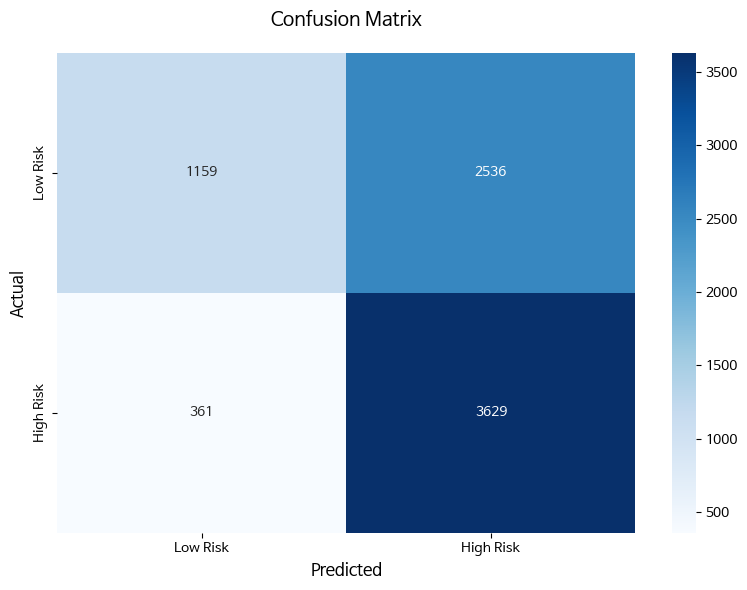

In [24]:
# Confusion Matrix 시각화
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Low Risk', 'High Risk'],
    yticklabels=['Low Risk', 'High Risk'],
    ax=ax
)
ax.set_title('Confusion Matrix', fontsize=14, pad=20)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

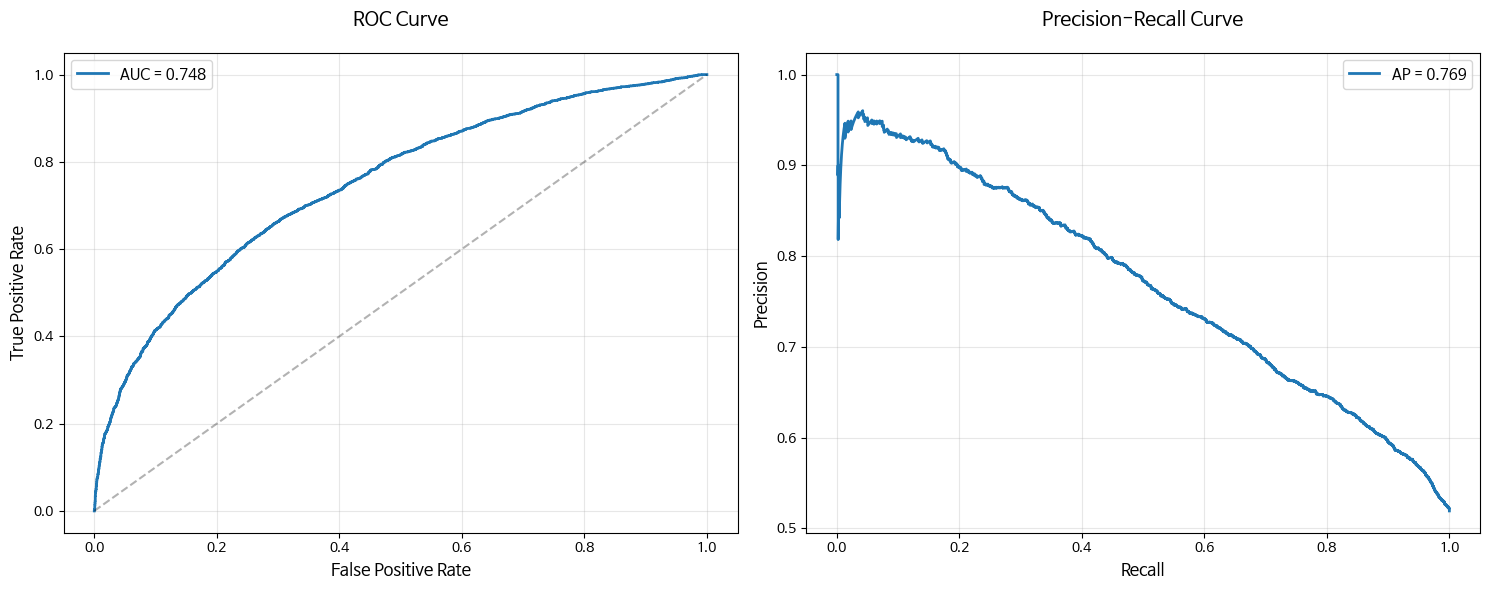

In [25]:
# ROC Curve & Precision-Recall Curve
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
axes[0].plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.3f}')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, pad=20)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba[:, 1])
ap = average_precision_score(y_test, y_test_proba[:, 1])
axes[1].plot(recall_test, precision_test, linewidth=2, label=f'AP = {ap:.3f}')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, pad=20)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

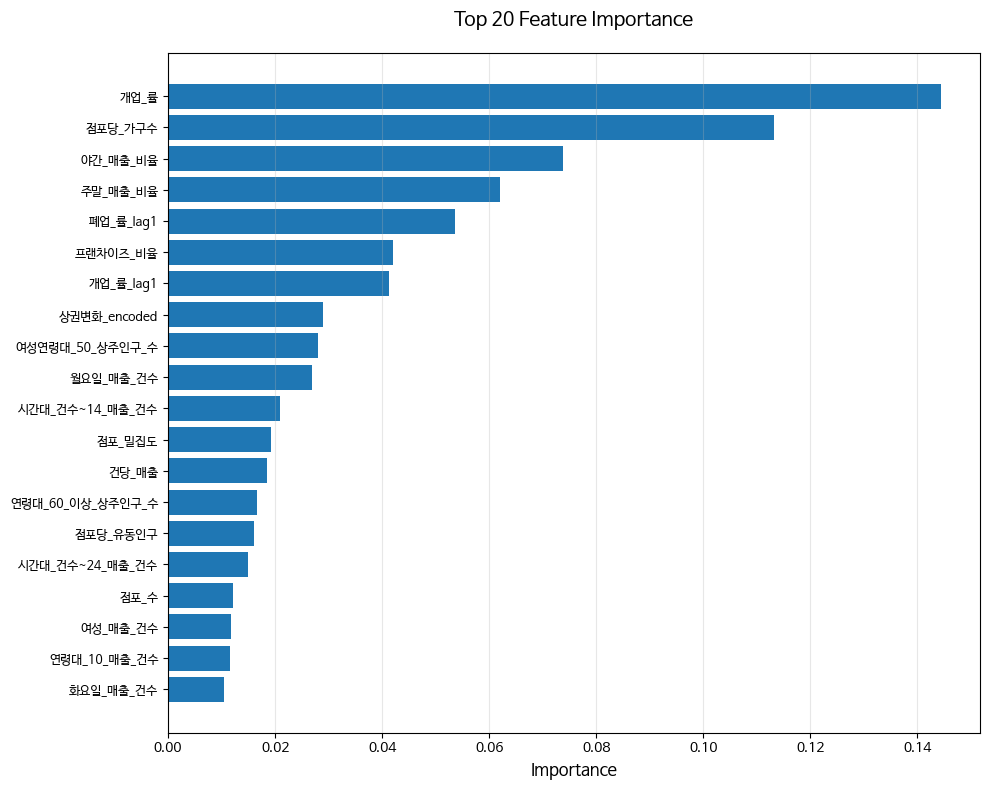


Top 20 중요 Feature:
              feature  importance
2                개업_률    0.144476
149           점포당_가구수    0.113263
143          야간_매출_비율    0.073695
142          주말_매출_비율    0.061948
138         폐업_률_lag1    0.053632
153          프랜차이즈_비율    0.042098
137         개업_률_lag1    0.041209
133      상권변화_encoded    0.028971
107   여성연령대_50_상주인구_수    0.028036
28          월요일_매출_건수    0.026807
37    시간대_건수~14_매출_건수    0.020881
152            점포_밀집도    0.019214
135             건당_매출    0.018415
96   연령대_60_이상_상주인구_수    0.016639
136          점포당_유동인구    0.016033
40    시간대_건수~24_매출_건수    0.014919
0                점포_수    0.012044
42           여성_매출_건수    0.011687
43       연령대_10_매출_건수    0.011552
29          화요일_매출_건수    0.010376


In [26]:
# Feature Importance (Top 20)
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importances
}).sort_values('importance', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(importance_df)), importance_df['importance'])
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['feature'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 20 Feature Importance', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 20 중요 Feature:")
print(importance_df)

In [27]:
# # 테스트 데이터에서 설명하고 싶은 샘플 하나를 선택 (예: 첫 번째 데이터)
# sample_idx = 0
# X_sample = X_test_scaled[sample_idx].reshape(1, -1)
# y_sample_actual = y_test[sample_idx]
# y_sample_pred_prob = model.predict_proba(X_sample)[0, 1]

# print(f"샘플 {sample_idx}번 데이터 분석")
# print(f"실제 값: {'High Risk' if y_sample_actual == 1 else 'Low Risk'}")
# print(f"예측 확률 (High Risk): {y_sample_pred_prob:.4f}")

# # 모델의 explain 기능으로 어텐션 마스크 추출
# masks, _ = model.explain(X_sample)

# # 마스크 시각화
# fig, ax = plt.subplots(figsize=(12, 8))
# im = ax.imshow(masks[0], cmap='viridis')
# ax.set_yticks(range(len(feature_cols)))
# ax.set_yticklabels(feature_cols, fontsize=8)
# ax.set_xlabel("Decision Steps")
# ax.set_ylabel("Features")
# ax.set_title(f"Feature Attentions for Sample {sample_idx}")
# fig.colorbar(im, ax=ax)
# plt.tight_layout()
# plt.show()

KeyError: 0

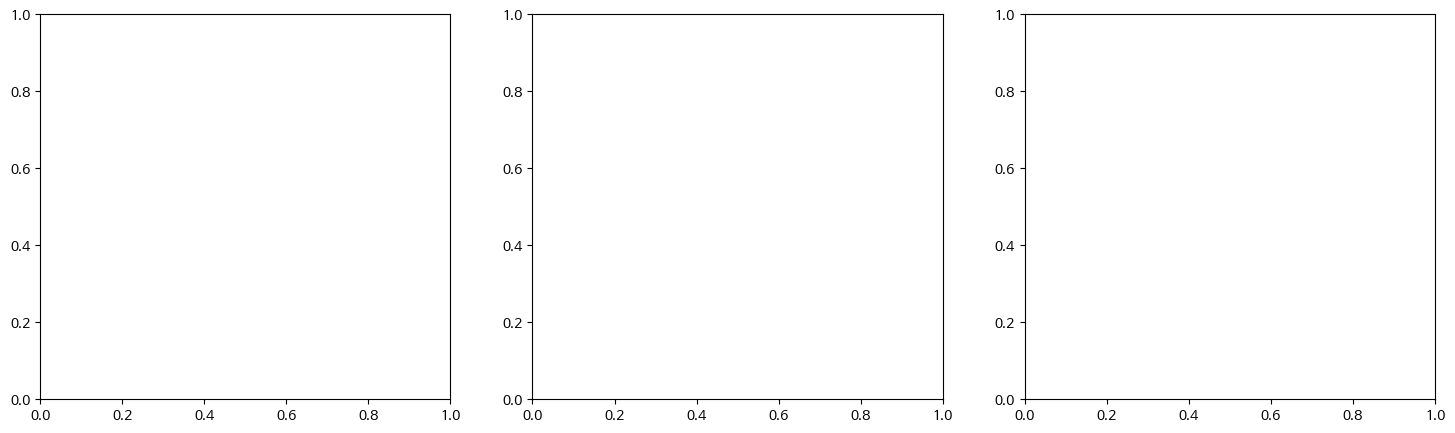

In [28]:
# Training History
history = model.history

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
if 'loss' in history:
    axes[0].plot(history['loss'], label='Train Loss', linewidth=2)
if 'val_0_loss' in history:
    axes[0].plot(history['val_0_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, pad=20)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
if 'train_accuracy' in history:
    axes[1].plot(history['train_accuracy'], label='Train Accuracy', linewidth=2)
if 'val_0_accuracy' in history:
    axes[1].plot(history['val_0_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, pad=20)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# AUC
if 'train_auc' in history:
    axes[2].plot(history['train_auc'], label='Train AUC', linewidth=2)
if 'val_0_auc' in history:
    axes[2].plot(history['val_0_auc'], label='Val AUC', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('AUC', fontsize=12)
axes[2].set_title('Training and Validation AUC', fontsize=14, pad=20)
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. 모델 저장

In [30]:
# 저장 디렉토리 생성
save_dir = Path('./saved_models')
save_dir.mkdir(exist_ok=True)

print("✓ 모델 및 데이터 저장")

# 모델 저장
model_path = save_dir / 'tabnet_closure_prediction.zip'
model.save_model(str(model_path))
print(f"  - 모델: {model_path}")

# Scaler 저장
scaler_path = save_dir / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"  - Scaler: {scaler_path}")

# Label Encoders 저장
encoders = {
    '자치구': le_district,
    '업종': le_industry
}
encoders_path = save_dir / 'label_encoders.pkl'
with open(encoders_path, 'wb') as f:
    pickle.dump(encoders, f)
print(f"  - Label Encoders: {encoders_path}")

# Feature 이름 저장
features_path = save_dir / 'feature_names.txt'
with open(features_path, 'w', encoding='utf-8') as f:
    for feat in feature_cols:
        f.write(f"{feat}\n")
print(f"  - Feature Names: {features_path}")

# 평가 결과 저장
results = {
    'optimal_threshold': float(optimal_threshold),
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1': float(f1),
    'auc': float(auc),
    'confusion_matrix': cm.tolist(),
    'best_epoch': int(model.best_epoch),
    'best_loss': float(model.best_cost)
}

results_path = save_dir / 'results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"  - Results: {results_path}")

# Feature Importance 저장
importance_path = save_dir / 'feature_importance.csv'
importance_df.to_csv(importance_path, index=False, encoding='utf-8-sig')
print(f"  - Feature Importance: {importance_path}")

✓ 모델 및 데이터 저장
Successfully saved model at saved_models/tabnet_closure_prediction.zip.zip
  - 모델: saved_models/tabnet_closure_prediction.zip
  - Scaler: saved_models/scaler.pkl
  - Label Encoders: saved_models/label_encoders.pkl
  - Feature Names: saved_models/feature_names.txt
  - Results: saved_models/results.json
  - Feature Importance: saved_models/feature_importance.csv


## 📊 최종 결과 요약

In [29]:
print("\n" + "="*80)
print(" " * 30 + "최종 결과 요약")
print("="*80)

print(f"\n✓ 모델: TabNet 폐업률 분류 예측")
print(f"✓ 디바이스: {device}")
print(f"✓ 최적 Threshold: {optimal_threshold:.4f}")
print(f"✓ Best Epoch: {model.best_epoch}")

print(f"\n✓ Test Set 성능:")
print(f"  - Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  - Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  - F1 Score:  {f1:.4f}")
print(f"  - AUC:       {auc:.4f}")

print(f"\n✓ 저장된 파일:")
print(f"  - 모델: {save_dir}/tabnet_closure_prediction.zip")
print(f"  - Scaler: {save_dir}/scaler.pkl")
print(f"  - Encoders: {save_dir}/label_encoders.pkl")
print(f"  - Features: {save_dir}/feature_names.txt")
print(f"  - Results: {save_dir}/results.json")
print(f"  - Importance: {save_dir}/feature_importance.csv")

print("\n" + "🎉 "*20)
print(" "*30 + "완료!")
print("🎉 "*20 + "\n")


                              최종 결과 요약

✓ 모델: TabNet 폐업률 분류 예측
✓ 디바이스: cuda
✓ 최적 Threshold: 0.3304
✓ Best Epoch: 74

✓ Test Set 성능:
  - Accuracy:  0.6230 (62.30%)
  - Precision: 0.5886 (58.86%)
  - Recall:    0.9095 (90.95%)
  - F1 Score:  0.7147
  - AUC:       0.7484

✓ 저장된 파일:


NameError: name 'save_dir' is not defined